In [30]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for plots 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
from tqdm import tqdm_notebook as tqdm 
import matplotlib.image as mpimg # Importing images for visualization and learning curves comparison (with/without outliers)
import scipy.optimize as opt # curve fitting 

#ANOVA
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# in order to plot inline, Jupyter Notebook only 
%matplotlib inline

## My functions 

In [31]:
# Find Outliers -- upper and lower limit to 3 std 

def find_outliers(random_data):
    anomalies = []
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std *3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

## Importing Data from .csv files

In [32]:
# Import all the .csv files 
trackFiles = []
trackFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Track/*.csv')

shapeFiles = []
shapeFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Shapes/*.csv')

relationsFiles = []
relationsFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Relations/*.csv')

In [33]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    regExpr2 = re.compile(r'p_shape')
    regExpr3 = re.compile(r'p_relations')
    
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    probeShapesFiles = list(filter(lambda i : regExpr2.search(i), shapeFiles))
    probeRelationsFiles = list(filter(lambda i : regExpr3.search(i), relationsFiles))
    
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    shapeFiles = list(filter(lambda i : not regExpr2.search(i), shapeFiles))
    relationsFiles = list(filter(lambda i : not regExpr3.search(i), relationsFiles))
    
    
else : 
    trackFiles = trackFiles 
    shapeFiles = shapeFiles
    relationsFiles = relationsFiles 


In [34]:
# Creating list of tracking Data as list of pandas dataframes 
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""
    


#Adding landmark name and color in order to create a new dataframe for shapes

landm_name = {'Shape': ['Triangle Lg', 'Triangle Sm',  'Square Lg', 'Square Sm', 'Circle Lg', 'Circle Sm', 'Food']} 
shape_names = pd.DataFrame(data = landm_name)

color_shapes = pd.DataFrame(data = np.linspace(0,1,7), columns= ['Color'])

shapeData = []
for i in tqdm(range(0,len(shapeFiles))) : 
    shapeData.append(pd.read_csv(shapeFiles[i], names = ["X", "Y", "Angle"]))
    shapeData[i] = pd.concat([shape_names,shapeData[i]], axis = 1)
    shapeData[i] = pd.concat([shapeData[i], color_shapes], axis = 1)
    
    """_shapes.csv files:
    Columns: X(m), Y(m), A(deg):
    X(m): x coordinate of the shape center @ grid frame of reference
    Y(m): y coordinate of the shape center @ grid frame of reference
    A(deg): Shape orientation
    Rows: "Triangle Lg", "Triangle Sm", "Square Lg", "Square Sm", "Circle Lg", "Circle Sm", "Food", """
    
    
relationsData = []
for i in tqdm(range(0,len(relationsFiles))) : 
    relationsData.append(pd.read_csv(relationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))

    """_relations.csv files:
       Columns: T(s), D_F(m), A_E(deg), L_"Triangle Lg"(bool), L_"Triangle Sm"(bool), L_"Square Lg"(bool), L_"Square Sm"(bool), L_"Circle Lg"(bool), L_"Circle Sm"(bool), L_"Food"(bool), 
       T: camera frame time
       D_F: distance to the food
       A_E: heading angle error (food_vec - head_vec, 0..90 deg)
       L_"x": Is shape "x" adjacent to the head position? 0:no, 1:yes"""

# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFiles))) : 
    probeData.append(pd.read_csv(probeFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    
probeRelationsData = [] 
for i in tqdm(range(0,len(probeRelationsFiles))) : 
    probeRelationsData.append(pd.read_csv(probeRelationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))
    


In [35]:
#Quick consistency check 
len(trackData) == len(shapeData) ==len(relationsData)

True

In [36]:
indexFishA = []
indexFishB = [] 
indexFishC = [] 
indexFishD = [] 

for i in range(0,len(trackFiles)):
    if trackFiles[i][-12] == 'A':
        indexFishA.append(i)
        
    elif trackFiles[i][-12] == 'B':
        indexFishB.append(i)
        
    elif trackFiles[i][-12] == 'C':
        indexFishC.append(i)
        
    elif trackFiles[i][-12] == 'D':
        indexFishD.append(i)      

indexFishAProbe = []
indexFishBProbe = [] 
indexFishCProbe = [] 
indexFishDProbe = [] 

for i in range(0,len(probeFiles)):
    if probeFiles[i][-13] == 'A':
        indexFishAProbe.append(i)
        
    elif probeFiles[i][-13] == 'B':
        indexFishBProbe.append(i)
        
    elif probeFiles[i][-13] == 'C':
        indexFishCProbe.append(i)
        
    elif probeFiles[i][-13] == 'D':
        indexFishDProbe.append(i)      

        

trackDataFishA = []
trackDataFishB = []
trackDataFishC = []
trackDataFishD = []
trackDataFishA_B = [] 

#for i in range(0, len(df_for_sampling_density_analysis)):
for j in indexFishA:
    trackDataFishA.append(pd.read_csv(trackFiles[j], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
for j in indexFishB:
    trackDataFishB.append(pd.read_csv(trackFiles[j], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
for j in indexFishC:
    trackDataFishC.append(pd.read_csv(trackFiles[j], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
for j in indexFishD:
    trackDataFishD.append(pd.read_csv(trackFiles[j], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    
probeDataFishA = []
probeDataFishB = []

for j in indexFishAProbe: 
    probeDataFishA.append(pd.read_csv(probeFiles[j] , names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    
for j in indexFishBProbe:
    probeDataFishB.append(pd.read_csv(probeFiles[j] , names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))

# Bar Plots 

### Distance Bar Plots 

In [37]:
early_ends_at = 13 
posDifferenceProbe = []
for i in range(0,len(probeData)):
    pivotVar = probeData[i].diff().drop(columns = ['HeadAngle', 'Time'])
    posDifferenceProbe.append(pivotVar.drop(pivotVar.index[0]))

distanceProbe = []
for i in range(0,len(posDifferenceProbe)):
    distanceProbe.append(posDifferenceProbe[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
    distanceProbe[i].columns = ['distanceProbe']

distanceTotProbe = []
for i in range(0,len(distanceProbe)):
    distanceTotProbe.append(distanceProbe[i].sum())
    distanceTotProbe[i] = distanceTotProbe[i][0]

distanceTotProbe = np.asarray(distanceTotProbe)

posDifferenceEarly = []
for i in range(0,early_ends_at ):
    pivotVar = trackData[i].diff().drop(columns = ['HeadAngle', 'Time'])
    posDifferenceEarly.append(pivotVar.drop(pivotVar.index[0]))

distanceEarly = []
for i in range(0,len(posDifferenceEarly)):
    distanceEarly.append(posDifferenceEarly[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
    distanceEarly[i].columns = ['distanceEarly']

distanceTotEarly = []
for i in range(0,len(distanceEarly)):
    distanceTotEarly.append(distanceEarly[i].sum())
    distanceTotEarly[i] = distanceTotEarly[i][0]

distanceTotEarly = np.asarray(distanceTotEarly)
#distanceTotEarly = np.delete(distanceTotEarly, 12)

#late_start_from = 127# Session 13 
late_start_from = 229 # Session 20 --> less fluctuations

posDifferenceLate = []
for i in range(late_start_from,len(trackData)):
    pivotVar = trackData[i].diff().drop(columns = ['HeadAngle', 'Time'])
    posDifferenceLate.append(pivotVar.drop(pivotVar.index[0]))

distanceLate = []
for i in range(0,len(posDifferenceLate)):
    distanceLate.append(posDifferenceLate[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
    distanceLate[i].columns = ['distanceLate']

distanceTotLate = []
for i in range(0,len(distanceLate)):
    distanceTotLate.append(distanceLate[i].sum())
    distanceTotLate[i] = distanceTotLate[i][0]

distanceTotLate = np.asarray(distanceTotLate)

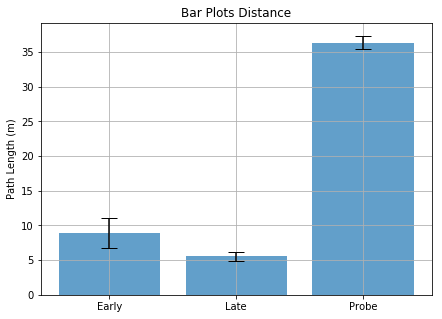

In [38]:
objects = ('Early', 'Late', 'Probe')
y_pos = np.arange(len(objects))
distance = [distanceTotEarly.mean(), distanceTotLate.mean(), distanceTotProbe.mean()]
distance_error = [distanceTotEarly.std()/(np.sqrt(len(distanceTotEarly))), distanceTotLate.std()/(np.sqrt(len(distanceTotLate))),
                distanceTotProbe.std()/(np.sqrt(len(distanceTotProbe)))]

plt.figure(0, figsize=(7,5))
plt.bar(y_pos, distance, yerr = distance_error,align = 'center', alpha = 0.7, capsize = 8 )
plt.grid()
plt.xticks(y_pos, objects)
plt.ylabel('Path Length (m)')
plt.title('Bar Plots Distance')
plt.savefig('Images/Shuffle/DistanceBars.png')


### Time Bar Plots 

In [39]:
## Time Bar Plots 

durationEarly = []

for i in range(0,early_ends_at ):
    durationEarly.append(trackData[i].iloc[-1]['Time'] - trackData[i].iloc[0]['Time'])
    
    
durationEarly = np.asarray(durationEarly)
find_outliers(durationEarly)
if len(find_outliers(durationEarly)) > 0 : 
    durationEarly = durationEarly[durationEarly != find_outliers(durationEarly)[0]]

durationLate = []

for i in range(late_start_from, len(trackData)):
    durationLate.append(trackData[i].iloc[-1]['Time'] - trackData[i].iloc[0]['Time'])

durationLate = np.asarray(durationLate)

durationProbe = []

for i in range(0,len(probeData)):
    durationProbe.append(probeData[i].iloc[-1]['Time'] - probeData[i].iloc[0]['Time'])
    
durationProbe = np.asarray(durationProbe)

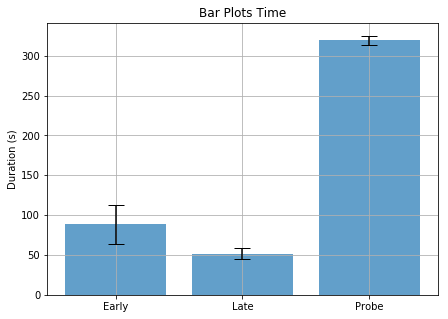

In [40]:
objects1 = ('Early', 'Late', 'Probe')
y_pos1 = np.arange(len(objects1))
duration = [durationEarly.mean(), durationLate.mean(), durationProbe.mean()]
duration_error = [durationEarly.std()/(np.sqrt(len(durationEarly))), durationLate.std()/(np.sqrt(len(durationLate))),
                durationProbe.std()/(np.sqrt(len(durationProbe)))]

plt.figure(1, figsize = (7,5))
plt.bar(y_pos1, duration, yerr = duration_error,align = 'center', alpha = 0.7, capsize = 8 )
plt.xticks(y_pos1, objects1)
plt.grid()
plt.ylabel('Duration (s)')
plt.title('Bar Plots Time')
plt.savefig('Images/Shuffle/DurationBars.png')

### Speed Bar Plots 

In [41]:
# Quick consistency check 
len(distanceTotEarly) == len(durationEarly) and len(distanceTotLate) == len(durationLate)

True

In [42]:
speedEarly = []
for i in range(0, len(distanceTotEarly)):
    speedEarly.append(distanceTotEarly[i]/durationEarly[i])
    
speedEarly = np.asarray(speedEarly)

speedLate = []
for i in range(0, len(distanceTotLate)):
    speedLate.append(distanceTotLate[i]/durationLate[i])

speedLate = np.asarray(speedLate)
    
speedProbe = []
for i in range(0, len(distanceTotProbe)):
    speedProbe.append(distanceTotProbe[i]/durationProbe[i])

speedProbe = np.asarray(speedProbe)

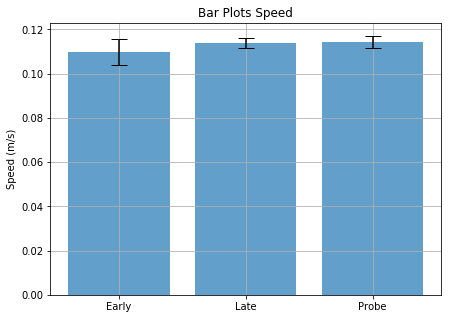

In [43]:
objects3 = ('Early', 'Late', 'Probe')
y_pos3 = np.arange(len(objects3))
speed = [speedEarly.mean(), speedLate.mean(), speedProbe.mean()]
speed_error = [speedEarly.std()/(np.sqrt(len(speedEarly))), speedLate.std()/(np.sqrt(len(speedLate))),
                speedProbe.std()/(np.sqrt(len(speedProbe)))]

plt.figure(1, figsize = (7,5))
plt.bar(y_pos3, speed, yerr = speed_error,align = 'center', alpha = 0.7, capsize = 8 )
plt.xticks(y_pos3, objects3)
plt.grid()
plt.ylabel('Speed (m/s)')
plt.title('Bar Plots Speed')
plt.savefig('Images/Shuffle/SpeedBars.png')

## Filtering Probe Trials 
Previous probe trials time and distance didn't take into account the fact that the food is not there anymore, so we have to stop the trial whenever the fish reach a neighborhood of the shape related to food (Large Triangle). 
Let's filter our data in this way and see what happens

### Distance (Path Length)

In [85]:
probeFilteredFiles = []
probeFilteredFiles = glob.glob(r'C:\Users\jamesjun\Desktop\Simone\TrackFiles\TrajectoriesAnalysis\filteredProbeFiles\Track\*.csv')

In [86]:
probeFilteredData = []
for i in tqdm(range(0,len(probeFilteredFiles))) : 
    probeFilteredData.append(pd.read_csv(probeFilteredFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"], skiprows = 1))

In [87]:
posDifferenceFilteredProbe = []
for i in range(0,len(probeFilteredData)):
    pivotVar = probeFilteredData[i].diff().drop(columns = ['HeadAngle', 'Time', "EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"])
    posDifferenceFilteredProbe.append(pivotVar.drop(pivotVar.index[0]))

distanceFilteredProbe = []
for i in range(0,len(posDifferenceFilteredProbe)):
    distanceFilteredProbe.append(posDifferenceFilteredProbe[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
    distanceFilteredProbe[i].columns = ['distanceProbe']

distanceTotFilteredProbe = []
for i in range(0,len(distanceFilteredProbe)):
    distanceTotFilteredProbe.append(distanceFilteredProbe[i].sum())
    distanceTotFilteredProbe[i] = distanceTotFilteredProbe[i][0]

distanceTotFilteredProbe = np.asarray(distanceTotFilteredProbe)

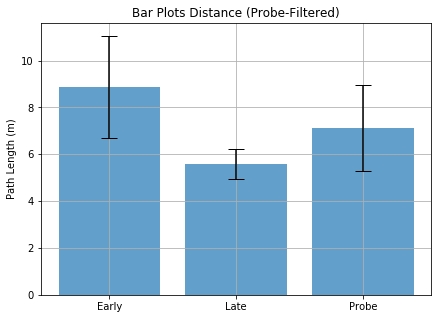

In [88]:
objects = ('Early', 'Late', 'Probe')
y_pos = np.arange(len(objects))
distance = [distanceTotEarly.mean(), distanceTotLate.mean(), distanceTotFilteredProbe.mean()]
distance_error = [distanceTotEarly.std()/(np.sqrt(len(distanceTotEarly))), distanceTotLate.std()/(np.sqrt(len(distanceTotLate))),
                distanceTotFilteredProbe.std()/(np.sqrt(len(distanceTotFilteredProbe)))]

plt.figure(0, figsize=(7,5))
plt.bar(y_pos, distance, yerr = distance_error,align = 'center', alpha = 0.7, capsize = 8 )
plt.grid()
plt.xticks(y_pos, objects)
plt.ylabel('Path Length (m)')
plt.title('Bar Plots Distance (Probe-Filtered)')
plt.savefig('Images/Shuffle/DistanceBarsFilteredProbe.png')


### Time (Duration)

In [89]:
durationFilteredProbe = []

for i in range(0,len(probeFilteredData)):
    durationFilteredProbe.append(probeFilteredData[i].iloc[-1]['Time'] - probeFilteredData[i].iloc[0]['Time'])
    
durationFilteredProbe = np.asarray(durationFilteredProbe)

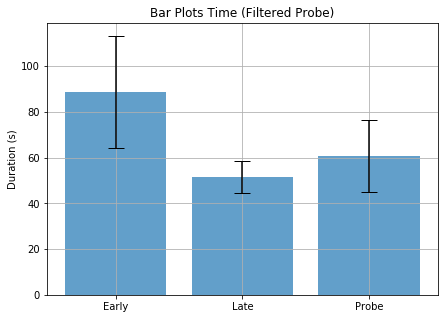

In [90]:
objects1 = ('Early', 'Late', 'Probe')
y_pos1 = np.arange(len(objects1))
duration = [durationEarly.mean(), durationLate.mean(), durationFilteredProbe.mean()]
duration_error = [durationEarly.std()/(np.sqrt(len(durationEarly))), durationLate.std()/(np.sqrt(len(durationLate))),
                durationFilteredProbe.std()/(np.sqrt(len(durationFilteredProbe)))]

plt.figure(1, figsize = (7,5))
plt.bar(y_pos1, duration, yerr = duration_error,align = 'center', alpha = 0.7, capsize = 8 )
plt.xticks(y_pos1, objects1)
plt.grid()
plt.ylabel('Duration (s)')
plt.title('Bar Plots Time (Filtered Probe)')
plt.savefig('Images/Shuffle/DurationBarsFiltered.png')

### Speed 

In [91]:
speedFilteredProbe = []
for i in range(0, len(distanceTotFilteredProbe)):
    speedFilteredProbe.append(distanceTotFilteredProbe[i]/durationFilteredProbe[i])

speedFilteredProbe = np.asarray(speedFilteredProbe)

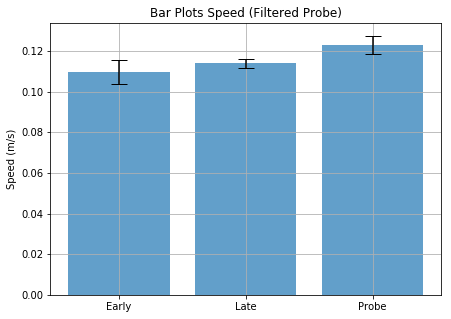

In [92]:
objects3 = ('Early', 'Late', 'Probe')
y_pos3 = np.arange(len(objects3))
speed = [speedEarly.mean(), speedLate.mean(), speedFilteredProbe.mean()]
speed_error = [speedEarly.std()/(np.sqrt(len(speedEarly))), speedLate.std()/(np.sqrt(len(speedLate))),
                speedFilteredProbe.std()/(np.sqrt(len(speedFilteredProbe)))]

plt.figure(1, figsize = (7,5))
plt.bar(y_pos3, speed, yerr = speed_error,align = 'center', alpha = 0.7, capsize = 8 )
plt.xticks(y_pos3, objects3)
plt.grid()
plt.ylabel('Speed (m/s)')
plt.title('Bar Plots Speed (Filtered Probe)')
plt.savefig('Images/Shuffle/SpeedBarsFiltered.png')

## Bar Plots Comparison

In [93]:
img1 = mpimg.imread('Images/Shuffle/DistanceBars.png')
img2 = mpimg.imread('Images/Shuffle/DistanceBarsFilteredProbe.png')
img3 = mpimg.imread('Images/Shuffle/DurationBars.png')
img4 = mpimg.imread('Images/Shuffle/DurationBarsFiltered.png')
img5 = mpimg.imread('Images/Shuffle/SpeedBars.png')
img6 = mpimg.imread('Images/Shuffle/SpeedBarsFiltered.png')

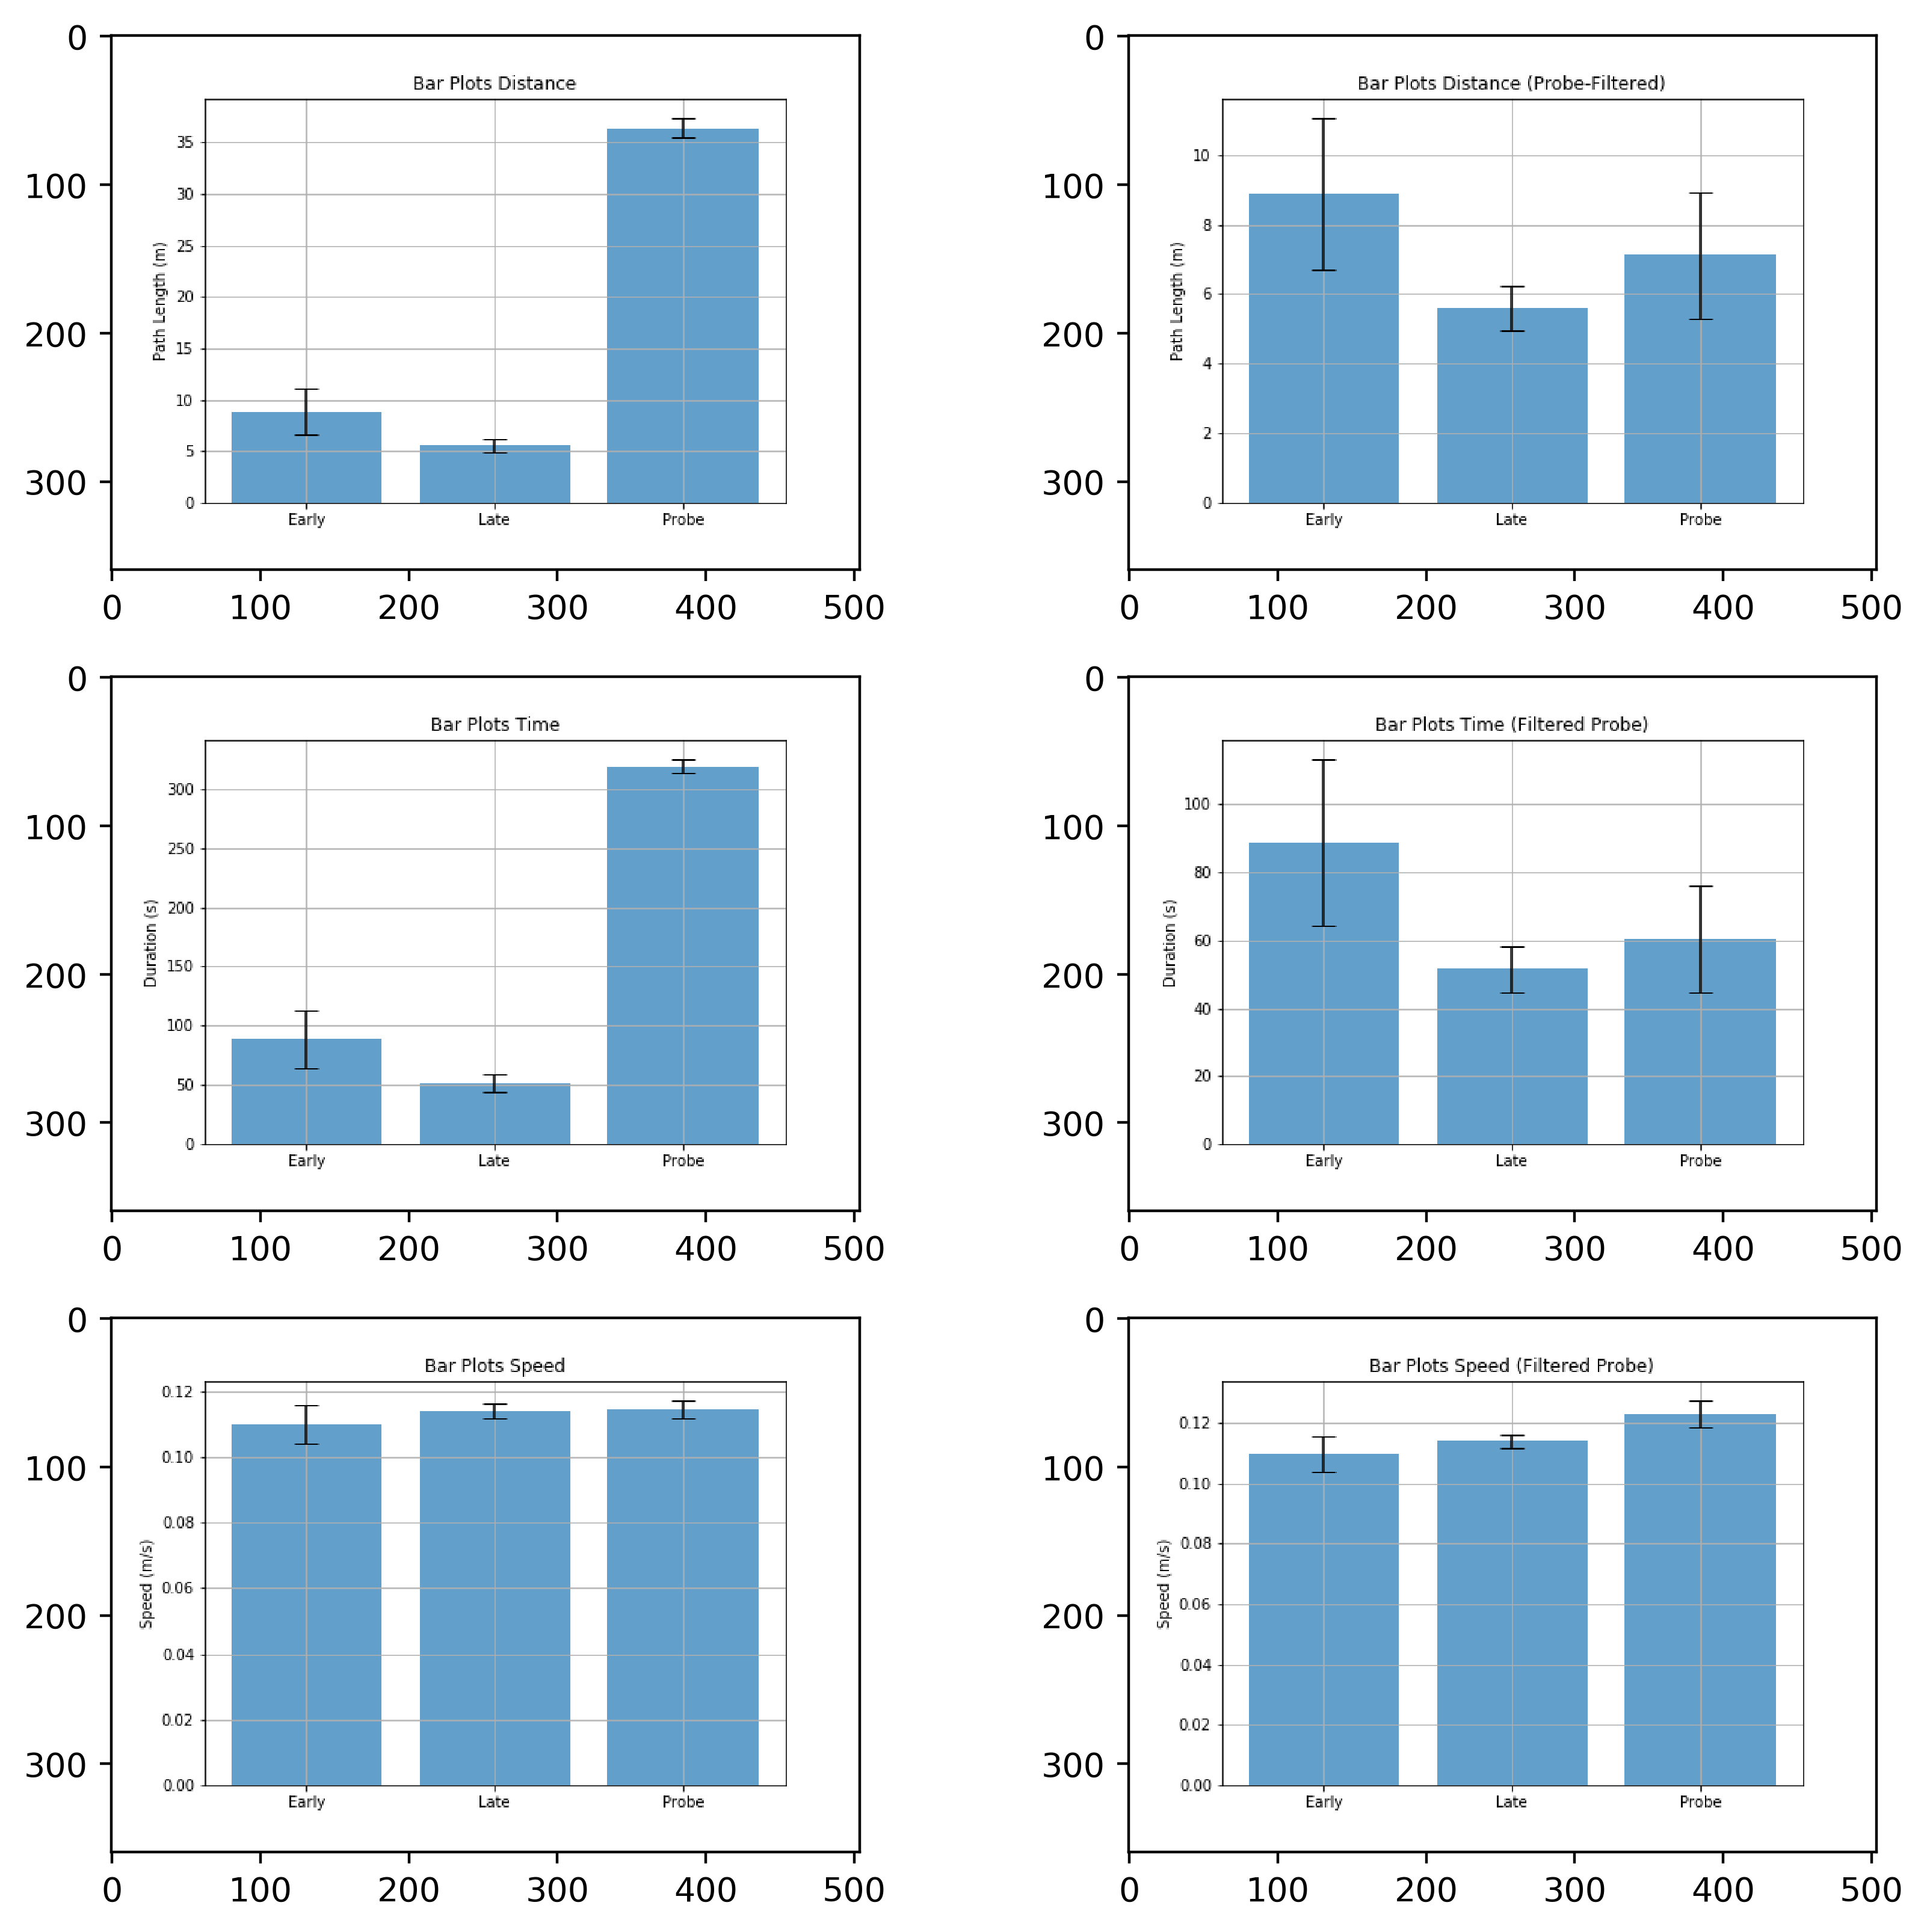

In [94]:
f, axarr = plt.subplots(3,2, figsize=(10,10), dpi = 400)
axarr[0,0].imshow(img1)
axarr[0,1].imshow(img2)
axarr[1,0].imshow(img3)
axarr[1,1].imshow(img4)
axarr[2,0].imshow(img5)
axarr[2,1].imshow(img6)

# Learning Curves 

Distance vs session # and Duration vs Session # 

In [55]:
session_number = 29 # 29 Sessions --> take a look at how many runs there were 
groupList = []

for i in range(2,10):
    groupRegex = re.compile(r'S0'+str(i))
    group = list(filter(lambda i : groupRegex.search(i), trackFiles))
    groupList.append(group)
    
for i in range(10, session_number + 1):
    groupRegex1 = re.compile(r'S'+str(i))
    group1 = list(filter(lambda i : groupRegex1.search(i), trackFiles))
    groupList.append(group1)

In [56]:
# In this way groupData[0] will be a multidimensional dataFrame
# i.e. groupData[0][0] corresponds to the first run in the first session
#(pay attention, first session is C02 but corresponds to index 0, so last session has index 15 instead of 17)

groupData = []
for i in tqdm(range(0,len(groupList))) : 
    pivotList = []
    for j in range(0, len(groupList[i])):
        pivotList.append(pd.read_csv(groupList[i][j], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
        
    groupData.append(pivotList)
    
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""

In [57]:
# Get duration for each run in each session 
durationSession0 = []
for i in range(0,len(groupData[0])):
	durationSession0.append(groupData[0][i].iloc[-1]['Time'] - groupData[0][i].iloc[0]['Time'])
durationSession1 = []
for i in range(0,len(groupData[1])):
	durationSession1.append(groupData[1][i].iloc[-1]['Time'] - groupData[1][i].iloc[0]['Time'])
durationSession2 = []
for i in range(0,len(groupData[2])):
	durationSession2.append(groupData[2][i].iloc[-1]['Time'] - groupData[2][i].iloc[0]['Time'])
durationSession3 = []
for i in range(0,len(groupData[3])):
	durationSession3.append(groupData[3][i].iloc[-1]['Time'] - groupData[3][i].iloc[0]['Time'])
durationSession4 = []
for i in range(0,len(groupData[4])):
	durationSession4.append(groupData[4][i].iloc[-1]['Time'] - groupData[4][i].iloc[0]['Time'])
durationSession5 = []
for i in range(0,len(groupData[5])):
	durationSession5.append(groupData[5][i].iloc[-1]['Time'] - groupData[5][i].iloc[0]['Time'])
durationSession6 = []
for i in range(0,len(groupData[6])):
	durationSession6.append(groupData[6][i].iloc[-1]['Time'] - groupData[6][i].iloc[0]['Time'])
durationSession7 = []
for i in range(0,len(groupData[7])):
	durationSession7.append(groupData[7][i].iloc[-1]['Time'] - groupData[7][i].iloc[0]['Time'])
durationSession8 = []
for i in range(0,len(groupData[8])):
	durationSession8.append(groupData[8][i].iloc[-1]['Time'] - groupData[8][i].iloc[0]['Time'])
durationSession9 = []
for i in range(0,len(groupData[9])):
	durationSession9.append(groupData[9][i].iloc[-1]['Time'] - groupData[9][i].iloc[0]['Time'])
durationSession10 = []
for i in range(0,len(groupData[10])):
	durationSession10.append(groupData[10][i].iloc[-1]['Time'] - groupData[10][i].iloc[0]['Time'])
durationSession11 = []
for i in range(0,len(groupData[11])):
	durationSession11.append(groupData[11][i].iloc[-1]['Time'] - groupData[11][i].iloc[0]['Time'])
durationSession12 = []
for i in range(0,len(groupData[12])):
	durationSession12.append(groupData[12][i].iloc[-1]['Time'] - groupData[12][i].iloc[0]['Time'])
durationSession13 = []
for i in range(0,len(groupData[13])):
	durationSession13.append(groupData[13][i].iloc[-1]['Time'] - groupData[13][i].iloc[0]['Time'])
durationSession14 = []
for i in range(0,len(groupData[14])):
	durationSession14.append(groupData[14][i].iloc[-1]['Time'] - groupData[14][i].iloc[0]['Time'])
durationSession15 = []
for i in range(0,len(groupData[15])):
	durationSession15.append(groupData[15][i].iloc[-1]['Time'] - groupData[15][i].iloc[0]['Time'])
durationSession16 = []
for i in range(0,len(groupData[16])):
	durationSession16.append(groupData[16][i].iloc[-1]['Time'] - groupData[16][i].iloc[0]['Time'])

durationSession17 = []
for i in range(0,len(groupData[17])):
	durationSession17.append(groupData[17][i].iloc[-1]['Time'] - groupData[17][i].iloc[0]['Time'])

durationSession18 = []
for i in range(0,len(groupData[18])):
	durationSession18.append(groupData[18][i].iloc[-1]['Time'] - groupData[18][i].iloc[0]['Time'])

durationSession19 = []
for i in range(0,len(groupData[19])):
	durationSession19.append(groupData[19][i].iloc[-1]['Time'] - groupData[19][i].iloc[0]['Time'])

durationSession20 = []
for i in range(0,len(groupData[20])):
	durationSession20.append(groupData[20][i].iloc[-1]['Time'] - groupData[20][i].iloc[0]['Time'])

durationSession21 = []
for i in range(0,len(groupData[21])):
	durationSession21.append(groupData[21][i].iloc[-1]['Time'] - groupData[21][i].iloc[0]['Time'])

durationSession22 = []
for i in range(0,len(groupData[22])):
	durationSession22.append(groupData[22][i].iloc[-1]['Time'] - groupData[22][i].iloc[0]['Time'])

durationSession23 = []
for i in range(0,len(groupData[23])):
	durationSession23.append(groupData[23][i].iloc[-1]['Time'] - groupData[23][i].iloc[0]['Time'])

durationSession24 = []
for i in range(0,len(groupData[24])):
	durationSession24.append(groupData[24][i].iloc[-1]['Time'] - groupData[24][i].iloc[0]['Time'])

durationSession25 = []
for i in range(0,len(groupData[25])):
	durationSession25.append(groupData[25][i].iloc[-1]['Time'] - groupData[25][i].iloc[0]['Time'])

durationSession26 = []
for i in range(0,len(groupData[26])):
	durationSession26.append(groupData[26][i].iloc[-1]['Time'] - groupData[26][i].iloc[0]['Time'])

durationSession27 = []
for i in range(0,len(groupData[27])):
	durationSession27.append(groupData[27][i].iloc[-1]['Time'] - groupData[27][i].iloc[0]['Time'])



#Convert Everything to a np.array
durationSession0=np.asarray(durationSession0)
durationSession1=np.asarray(durationSession1)
durationSession2=np.asarray(durationSession2)
durationSession3=np.asarray(durationSession3)
durationSession4=np.asarray(durationSession4)
durationSession5=np.asarray(durationSession5)
durationSession6=np.asarray(durationSession6)
durationSession7=np.asarray(durationSession7)
durationSession8=np.asarray(durationSession8)
durationSession9=np.asarray(durationSession9)
durationSession10=np.asarray(durationSession10)
durationSession11=np.asarray(durationSession11)
durationSession12=np.asarray(durationSession12)
durationSession13=np.asarray(durationSession13)
durationSession14=np.asarray(durationSession14)
durationSession15=np.asarray(durationSession15)
durationSession16=np.asarray(durationSession16)
durationSession17=np.asarray(durationSession17)
durationSession18=np.asarray(durationSession18)
durationSession19=np.asarray(durationSession19)
durationSession20=np.asarray(durationSession20)
durationSession21=np.asarray(durationSession21)
durationSession22=np.asarray(durationSession22)
durationSession23=np.asarray(durationSession23)
durationSession24=np.asarray(durationSession24)
durationSession25=np.asarray(durationSession25)
durationSession26=np.asarray(durationSession26)
durationSession27=np.asarray(durationSession27)

# Now get average and standard deviation for each 

meanSession0=durationSession0.mean()
errorSession0=durationSession0.std()/np.sqrt(len(durationSession0))
meanSession1=durationSession1.mean()
errorSession1=durationSession1.std()/np.sqrt(len(durationSession1))
meanSession2=durationSession2.mean()
errorSession2=durationSession2.std()/np.sqrt(len(durationSession2))
meanSession3=durationSession3.mean()
errorSession3=durationSession3.std()/np.sqrt(len(durationSession3))
meanSession4=durationSession4.mean()
errorSession4=durationSession4.std()/np.sqrt(len(durationSession4))
meanSession5=durationSession5.mean()
errorSession5=durationSession5.std()/np.sqrt(len(durationSession5))
meanSession6=durationSession6.mean()
errorSession6=durationSession6.std()/np.sqrt(len(durationSession6))
meanSession7=durationSession7.mean()
errorSession7=durationSession7.std()/np.sqrt(len(durationSession7))
meanSession8=durationSession8.mean()
errorSession8=durationSession8.std()/np.sqrt(len(durationSession8))
meanSession9=durationSession9.mean()
errorSession9=durationSession9.std()/np.sqrt(len(durationSession9))
meanSession10=durationSession10.mean()
errorSession10=durationSession10.std()/np.sqrt(len(durationSession10))
meanSession11=durationSession11.mean()
errorSession11=durationSession11.std()/np.sqrt(len(durationSession11))
meanSession12=durationSession12.mean()
errorSession12=durationSession12.std()/np.sqrt(len(durationSession12))
meanSession13=durationSession13.mean()
errorSession13=durationSession13.std()/np.sqrt(len(durationSession13))
meanSession14=durationSession14.mean()
errorSession14=durationSession14.std()/np.sqrt(len(durationSession14))
meanSession15=durationSession15.mean()
errorSession15=durationSession15.std()/np.sqrt(len(durationSession15))
meanSession16=durationSession16.mean()
errorSession16=durationSession16.std()/np.sqrt(len(durationSession16))
meanSession17=durationSession17.mean()
errorSession17=durationSession17.std()/np.sqrt(len(durationSession17))
meanSession18=durationSession18.mean()
errorSession18=durationSession18.std()/np.sqrt(len(durationSession18))
meanSession19=durationSession19.mean()
errorSession19=durationSession19.std()/np.sqrt(len(durationSession19))
meanSession20=durationSession20.mean()
errorSession20=durationSession20.std()/np.sqrt(len(durationSession20))
meanSession21=durationSession21.mean()
errorSession21=durationSession21.std()/np.sqrt(len(durationSession21))
meanSession22=durationSession22.mean()
errorSession22=durationSession22.std()/np.sqrt(len(durationSession22))
meanSession23=durationSession23.mean()
errorSession23=durationSession23.std()/np.sqrt(len(durationSession23))
meanSession24=durationSession24.mean()
errorSession24=durationSession24.std()/np.sqrt(len(durationSession24))
meanSession25=durationSession25.mean()
errorSession25=durationSession25.std()/np.sqrt(len(durationSession25))
meanSession26=durationSession26.mean()
errorSession26=durationSession26.std()/np.sqrt(len(durationSession26))
meanSession27=durationSession27.mean()
errorSession27=durationSession27.std()/np.sqrt(len(durationSession27))

In [58]:
meanValues = np.array([meanSession0,meanSession1,meanSession2,meanSession3,meanSession4,meanSession5,
                       meanSession6,meanSession7,meanSession8,meanSession9,meanSession10,meanSession11,
                       meanSession12,meanSession13,meanSession14,meanSession15, meanSession16,meanSession17,
                       meanSession18,meanSession19,meanSession20,meanSession21,meanSession22,meanSession23,
                       meanSession24,meanSession25,meanSession26,meanSession27])
errorValues = np.array([errorSession0,errorSession1,errorSession2,errorSession3,errorSession4,errorSession5,
                        errorSession6,errorSession7,errorSession8,errorSession9,errorSession10,errorSession11,
                        errorSession12,errorSession13,errorSession14,errorSession15, errorSession16,errorSession17,
                        errorSession18,errorSession19,errorSession20,errorSession21,errorSession22,errorSession23,
                        errorSession24,errorSession25,errorSession26,errorSession27])

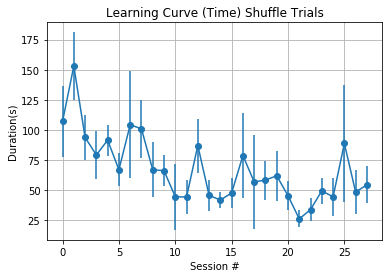

In [59]:
fig, ax = plt.subplots()
session = np.linspace(0,27,28)
ax.errorbar(session, meanValues,
            yerr=errorValues,
            fmt='-o')
plt.grid()


ax.set_xlabel('Session #')
ax.set_ylabel('Duration(s)')
ax.set_title('Learning Curve (Time) Shuffle Trials')

plt.savefig("Images/Shuffle/duration.png")

plt.show()

In [60]:
# remove outliers from arrays arr = arr[arr != 6] 
if len(find_outliers(durationSession0)) == 1: 
	durationSession0 = durationSession0[durationSession0 != find_outliers(durationSession0)[0]]
if len(find_outliers(durationSession1)) == 1: 
	durationSession1 = durationSession1[durationSession1 != find_outliers(durationSession1)[0]]
if len(find_outliers(durationSession2)) == 1: 
	durationSession2 = durationSession2[durationSession2 != find_outliers(durationSession2)[0]]
if len(find_outliers(durationSession3)) == 1: 
	durationSession3 = durationSession3[durationSession3 != find_outliers(durationSession3)[0]]
if len(find_outliers(durationSession4)) == 1: 
	durationSession4 = durationSession4[durationSession4 != find_outliers(durationSession4)[0]]
if len(find_outliers(durationSession5)) == 1: 
	durationSession5 = durationSession5[durationSession5 != find_outliers(durationSession5)[0]]
if len(find_outliers(durationSession6)) == 1: 
	durationSession6 = durationSession6[durationSession6 != find_outliers(durationSession6)[0]]
if len(find_outliers(durationSession7)) == 1: 
	durationSession7 = durationSession7[durationSession7 != find_outliers(durationSession7)[0]]
if len(find_outliers(durationSession8)) == 1: 
	durationSession8 = durationSession8[durationSession8 != find_outliers(durationSession8)[0]]
if len(find_outliers(durationSession9)) == 1: 
	durationSession9 = durationSession9[durationSession9 != find_outliers(durationSession9)[0]]
if len(find_outliers(durationSession10)) == 1: 
	durationSession10 = durationSession10[durationSession10 != find_outliers(durationSession10)[0]]
if len(find_outliers(durationSession11)) == 1: 
	durationSession11 = durationSession11[durationSession11 != find_outliers(durationSession11)[0]]
if len(find_outliers(durationSession12)) == 1: 
	durationSession12 = durationSession12[durationSession12 != find_outliers(durationSession12)[0]]
if len(find_outliers(durationSession13)) == 1: 
	durationSession13 = durationSession13[durationSession13 != find_outliers(durationSession13)[0]]
if len(find_outliers(durationSession14)) == 1: 
	durationSession14 = durationSession14[durationSession14 != find_outliers(durationSession14)[0]]
if len(find_outliers(durationSession15)) == 1: 
	durationSession15 = durationSession15[durationSession15 != find_outliers(durationSession15)[0]]
if len(find_outliers(durationSession16)) == 1:
	durationSession16 = durationSession16[durationSession16 != find_outliers(durationSession16)[0]]
if len(find_outliers(durationSession17)) == 1:
	durationSession17 = durationSession17[durationSession17 != find_outliers(durationSession17)[0]]
if len(find_outliers(durationSession18)) == 1:
	durationSession18 = durationSession18[durationSession18 != find_outliers(durationSession18)[0]]
if len(find_outliers(durationSession19)) == 1:
	durationSession19 = durationSession19[durationSession19 != find_outliers(durationSession19)[0]]
if len(find_outliers(durationSession20)) == 1:
	durationSession20 = durationSession20[durationSession20 != find_outliers(durationSession20)[0]]
if len(find_outliers(durationSession21)) == 1:
	durationSession21 = durationSession21[durationSession21 != find_outliers(durationSession21)[0]]
if len(find_outliers(durationSession22)) == 1:
	durationSession22 = durationSession22[durationSession22 != find_outliers(durationSession22)[0]]
if len(find_outliers(durationSession23)) == 1:
	durationSession23 = durationSession23[durationSession23 != find_outliers(durationSession23)[0]]
if len(find_outliers(durationSession24)) == 1:
	durationSession24 = durationSession24[durationSession24 != find_outliers(durationSession24)[0]]
if len(find_outliers(durationSession25)) == 1:
	durationSession25 = durationSession25[durationSession25 != find_outliers(durationSession25)[0]]
if len(find_outliers(durationSession26)) == 1:
	durationSession26 = durationSession26[durationSession26 != find_outliers(durationSession26)[0]]
if len(find_outliers(durationSession27)) == 1:
	durationSession27 = durationSession27[durationSession27 != find_outliers(durationSession27)[0]]

# Now get average and standard deviation for each 
meanSession0=durationSession0.mean()
errorSession0=durationSession0.std()/np.sqrt(len(durationSession0))
meanSession1=durationSession1.mean()
errorSession1=durationSession1.std()/np.sqrt(len(durationSession1))
meanSession2=durationSession2.mean()
errorSession2=durationSession2.std()/np.sqrt(len(durationSession2))
meanSession3=durationSession3.mean()
errorSession3=durationSession3.std()/np.sqrt(len(durationSession3))
meanSession4=durationSession4.mean()
errorSession4=durationSession4.std()/np.sqrt(len(durationSession4))
meanSession5=durationSession5.mean()
errorSession5=durationSession5.std()/np.sqrt(len(durationSession5))
meanSession6=durationSession6.mean()
errorSession6=durationSession6.std()/np.sqrt(len(durationSession6))
meanSession7=durationSession7.mean()
errorSession7=durationSession7.std()/np.sqrt(len(durationSession7))
meanSession8=durationSession8.mean()
errorSession8=durationSession8.std()/np.sqrt(len(durationSession8))
meanSession9=durationSession9.mean()
errorSession9=durationSession9.std()/np.sqrt(len(durationSession9))
meanSession10=durationSession10.mean()
errorSession10=durationSession10.std()/np.sqrt(len(durationSession10))
meanSession11=durationSession11.mean()
errorSession11=durationSession11.std()/np.sqrt(len(durationSession11))
meanSession12=durationSession12.mean()
errorSession12=durationSession12.std()/np.sqrt(len(durationSession12))
meanSession13=durationSession13.mean()
errorSession13=durationSession13.std()/np.sqrt(len(durationSession13))
meanSession14=durationSession14.mean()
errorSession14=durationSession14.std()/np.sqrt(len(durationSession14))
meanSession15=durationSession15.mean()
errorSession15=durationSession15.std()/np.sqrt(len(durationSession15))
meanSession16=durationSession16.mean()
errorSession16=durationSession16.std()/np.sqrt(len(durationSession16))
meanSession17=durationSession17.mean()
errorSession17=durationSession17.std()/np.sqrt(len(durationSession17))
meanSession18=durationSession18.mean()
errorSession18=durationSession18.std()/np.sqrt(len(durationSession18))
meanSession19=durationSession19.mean()
errorSession19=durationSession19.std()/np.sqrt(len(durationSession19))
meanSession20=durationSession20.mean()
errorSession20=durationSession20.std()/np.sqrt(len(durationSession20))
meanSession21=durationSession21.mean()
errorSession21=durationSession21.std()/np.sqrt(len(durationSession21))
meanSession22=durationSession22.mean()
errorSession22=durationSession22.std()/np.sqrt(len(durationSession22))
meanSession23=durationSession23.mean()
errorSession23=durationSession23.std()/np.sqrt(len(durationSession23))
meanSession24=durationSession24.mean()
errorSession24=durationSession24.std()/np.sqrt(len(durationSession24))
meanSession25=durationSession25.mean()
errorSession25=durationSession25.std()/np.sqrt(len(durationSession25))
meanSession26=durationSession26.mean()
errorSession26=durationSession26.std()/np.sqrt(len(durationSession26))
meanSession27=durationSession27.mean()
errorSession27=durationSession27.std()/np.sqrt(len(durationSession27))

In [61]:
meanValues = np.array([meanSession0,meanSession1,meanSession2,meanSession3,meanSession4,meanSession5,
                       meanSession6,meanSession7,meanSession8,meanSession9,meanSession10,meanSession11,
                       meanSession12,meanSession13,meanSession14,meanSession15,meanSession16,meanSession17
                       ,meanSession18,meanSession19,meanSession20,meanSession21,meanSession22,meanSession23
                       ,meanSession24,meanSession25,meanSession26,meanSession27])
errorValues = np.array([errorSession0,errorSession1,errorSession2,errorSession3,errorSession4,errorSession5,
                        errorSession6,errorSession7,errorSession8,errorSession9,errorSession10,errorSession11,
                        errorSession12,errorSession13,errorSession14,errorSession15,errorSession16,errorSession17
                        ,errorSession18,errorSession19,errorSession20,errorSession21,errorSession22,errorSession23,
                        errorSession24,errorSession25,errorSession26,errorSession27])

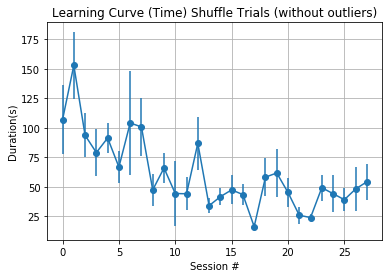

In [62]:
fig, ax = plt.subplots()
session = np.linspace(0,27,28)
ax.errorbar(session, meanValues,
            yerr=errorValues,
            fmt='-o')
plt.grid()


ax.set_xlabel('Session #')
ax.set_ylabel('Duration(s)')
ax.set_title('Learning Curve (Time) Shuffle Trials (without outliers)')

plt.savefig("Images/Shuffle/duration_no_outliers.png")
plt.show()

## Distance Learning Curve 


In [63]:
posDifference0 = []
for i in range(0,len(groupData[0])):
	pivotVar = groupData[0][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference0.append(pivotVar.drop(pivotVar.index[0]))
posDifference1 = []
for i in range(0,len(groupData[1])):
	pivotVar = groupData[1][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference1.append(pivotVar.drop(pivotVar.index[1]))
posDifference2 = []
for i in range(0,len(groupData[2])):
	pivotVar = groupData[2][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference2.append(pivotVar.drop(pivotVar.index[2]))
posDifference3 = []
for i in range(0,len(groupData[3])):
	pivotVar = groupData[3][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference3.append(pivotVar.drop(pivotVar.index[3]))
posDifference4 = []
for i in range(0,len(groupData[4])):
	pivotVar = groupData[4][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference4.append(pivotVar.drop(pivotVar.index[4]))
posDifference5 = []
for i in range(0,len(groupData[5])):
	pivotVar = groupData[5][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference5.append(pivotVar.drop(pivotVar.index[5]))
posDifference6 = []
for i in range(0,len(groupData[6])):
	pivotVar = groupData[6][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference6.append(pivotVar.drop(pivotVar.index[6]))
posDifference7 = []
for i in range(0,len(groupData[7])):
	pivotVar = groupData[7][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference7.append(pivotVar.drop(pivotVar.index[7]))
posDifference8 = []
for i in range(0,len(groupData[8])):
	pivotVar = groupData[8][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference8.append(pivotVar.drop(pivotVar.index[8]))
posDifference9 = []
for i in range(0,len(groupData[9])):
	pivotVar = groupData[9][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference9.append(pivotVar.drop(pivotVar.index[9]))
posDifference10 = []
for i in range(0,len(groupData[10])):
	pivotVar = groupData[10][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference10.append(pivotVar.drop(pivotVar.index[10]))
posDifference11 = []
for i in range(0,len(groupData[11])):
	pivotVar = groupData[11][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference11.append(pivotVar.drop(pivotVar.index[11]))
posDifference12 = []
for i in range(0,len(groupData[12])):
	pivotVar = groupData[12][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference12.append(pivotVar.drop(pivotVar.index[12]))
posDifference13 = []
for i in range(0,len(groupData[13])):
	pivotVar = groupData[13][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference13.append(pivotVar.drop(pivotVar.index[13]))
posDifference14 = []
for i in range(0,len(groupData[14])):
	pivotVar = groupData[14][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference14.append(pivotVar.drop(pivotVar.index[14]))
posDifference15 = []
for i in range(0,len(groupData[15])):
	pivotVar = groupData[15][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference15.append(pivotVar.drop(pivotVar.index[15]))
posDifference16 = []
for i in range(0,len(groupData[16])):
	pivotVar = groupData[16][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference16.append(pivotVar.drop(pivotVar.index[16]))
posDifference17 = []
for i in range(0,len(groupData[17])):
	pivotVar = groupData[17][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference17.append(pivotVar.drop(pivotVar.index[17]))
posDifference18 = []
for i in range(0,len(groupData[18])):
	pivotVar = groupData[18][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference18.append(pivotVar.drop(pivotVar.index[18]))
posDifference19 = []
for i in range(0,len(groupData[19])):
	pivotVar = groupData[19][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference19.append(pivotVar.drop(pivotVar.index[19]))
posDifference20 = []
for i in range(0,len(groupData[20])):
	pivotVar = groupData[20][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference20.append(pivotVar.drop(pivotVar.index[20]))
posDifference21 = []
for i in range(0,len(groupData[21])):
	pivotVar = groupData[21][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference21.append(pivotVar.drop(pivotVar.index[21]))
posDifference22 = []
for i in range(0,len(groupData[22])):
	pivotVar = groupData[22][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference22.append(pivotVar.drop(pivotVar.index[22]))
posDifference23 = []
for i in range(0,len(groupData[23])):
	pivotVar = groupData[23][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference23.append(pivotVar.drop(pivotVar.index[23]))
posDifference24 = []
for i in range(0,len(groupData[24])):
	pivotVar = groupData[24][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference24.append(pivotVar.drop(pivotVar.index[24]))
posDifference25 = []
for i in range(0,len(groupData[25])):
	pivotVar = groupData[25][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference25.append(pivotVar.drop(pivotVar.index[25]))
posDifference26 = []
for i in range(0,len(groupData[26])):
	pivotVar = groupData[26][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference26.append(pivotVar.drop(pivotVar.index[26]))
posDifference27 = []
for i in range(0,len(groupData[27])):
	pivotVar = groupData[27][i].diff().drop(columns = ['HeadAngle', 'Time','EODRate','DistanceXEODPulse','HeadSpeed', 'DistanceXESCAN'])
	posDifference27.append(pivotVar.drop(pivotVar.index[27]))


In [64]:
distance0 = []
for i in range(0,len(posDifference0)):
	distance0.append(posDifference0[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance0[i].columns = ['distance']
distance1 = []
for i in range(0,len(posDifference1)):
	distance1.append(posDifference1[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance1[i].columns = ['distance']
distance2 = []
for i in range(0,len(posDifference2)):
	distance2.append(posDifference2[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance2[i].columns = ['distance']
distance3 = []
for i in range(0,len(posDifference3)):
	distance3.append(posDifference3[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance3[i].columns = ['distance']
distance4 = []
for i in range(0,len(posDifference4)):
	distance4.append(posDifference4[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance4[i].columns = ['distance']
distance5 = []
for i in range(0,len(posDifference5)):
	distance5.append(posDifference5[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance5[i].columns = ['distance']
distance6 = []
for i in range(0,len(posDifference6)):
	distance6.append(posDifference6[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance6[i].columns = ['distance']
distance7 = []
for i in range(0,len(posDifference7)):
	distance7.append(posDifference7[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance7[i].columns = ['distance']
distance8 = []
for i in range(0,len(posDifference8)):
	distance8.append(posDifference8[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance8[i].columns = ['distance']
distance9 = []
for i in range(0,len(posDifference9)):
	distance9.append(posDifference9[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance9[i].columns = ['distance']
distance10 = []
for i in range(0,len(posDifference10)):
	distance10.append(posDifference10[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance10[i].columns = ['distance']
distance11 = []
for i in range(0,len(posDifference11)):
	distance11.append(posDifference11[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance11[i].columns = ['distance']
distance12 = []
for i in range(0,len(posDifference12)):
	distance12.append(posDifference12[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance12[i].columns = ['distance']
distance13 = []
for i in range(0,len(posDifference13)):
	distance13.append(posDifference13[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance13[i].columns = ['distance']
distance14 = []
for i in range(0,len(posDifference14)):
	distance14.append(posDifference14[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance14[i].columns = ['distance']
distance15 = []
for i in range(0,len(posDifference15)):
	distance15.append(posDifference15[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance15[i].columns = ['distance']
distance16 = []
for i in range(0,len(posDifference16)):
	distance16.append(posDifference16[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance16[i].columns = ['distance']
distance17 = []
for i in range(0,len(posDifference17)):
	distance17.append(posDifference17[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance17[i].columns = ['distance']
distance18 = []
for i in range(0,len(posDifference18)):
	distance18.append(posDifference18[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance18[i].columns = ['distance']
distance19 = []
for i in range(0,len(posDifference19)):
	distance19.append(posDifference19[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance19[i].columns = ['distance']
distance20 = []
for i in range(0,len(posDifference20)):
	distance20.append(posDifference20[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance20[i].columns = ['distance']
distance21 = []
for i in range(0,len(posDifference21)):
	distance21.append(posDifference21[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance21[i].columns = ['distance']
distance22 = []
for i in range(0,len(posDifference22)):
	distance22.append(posDifference22[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance22[i].columns = ['distance']
distance23 = []
for i in range(0,len(posDifference23)):
	distance23.append(posDifference23[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance23[i].columns = ['distance']
distance24 = []
for i in range(0,len(posDifference24)):
	distance24.append(posDifference24[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance24[i].columns = ['distance']
distance25 = []
for i in range(0,len(posDifference25)):
	distance25.append(posDifference25[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance25[i].columns = ['distance']
distance26 = []
for i in range(0,len(posDifference26)):
	distance26.append(posDifference26[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance26[i].columns = ['distance']
distance27 = []
for i in range(0,len(posDifference27)):
	distance27.append(posDifference27[i][['X' , 'Y']].apply(lambda x : np.linalg.norm(x) , axis = 1).to_frame())
	distance27[i].columns = ['distance']

In [65]:
distanceTot0 = []
for i in range(0,len(distance0)):
	distanceTot0.append(distance0[i].sum())
	distanceTot0[i] = distanceTot0[i][0]
distanceTot0= np.asarray(distanceTot0)

distanceTot1 = []
for i in range(0,len(distance1)):
	distanceTot1.append(distance1[i].sum())
	distanceTot1[i] = distanceTot1[i][0]
distanceTot1= np.asarray(distanceTot1)

distanceTot2 = []
for i in range(0,len(distance2)):
	distanceTot2.append(distance2[i].sum())
	distanceTot2[i] = distanceTot2[i][0]
distanceTot2= np.asarray(distanceTot2)

distanceTot3 = []
for i in range(0,len(distance3)):
	distanceTot3.append(distance3[i].sum())
	distanceTot3[i] = distanceTot3[i][0]
distanceTot3= np.asarray(distanceTot3)

distanceTot4 = []
for i in range(0,len(distance4)):
	distanceTot4.append(distance4[i].sum())
	distanceTot4[i] = distanceTot4[i][0]
distanceTot4= np.asarray(distanceTot4)

distanceTot5 = []
for i in range(0,len(distance5)):
	distanceTot5.append(distance5[i].sum())
	distanceTot5[i] = distanceTot5[i][0]
distanceTot5= np.asarray(distanceTot5)

distanceTot6 = []
for i in range(0,len(distance6)):
	distanceTot6.append(distance6[i].sum())
	distanceTot6[i] = distanceTot6[i][0]
distanceTot6= np.asarray(distanceTot6)

distanceTot7 = []
for i in range(0,len(distance7)):
	distanceTot7.append(distance7[i].sum())
	distanceTot7[i] = distanceTot7[i][0]
distanceTot7= np.asarray(distanceTot7)

distanceTot8 = []
for i in range(0,len(distance8)):
	distanceTot8.append(distance8[i].sum())
	distanceTot8[i] = distanceTot8[i][0]
distanceTot8= np.asarray(distanceTot8)

distanceTot9 = []
for i in range(0,len(distance9)):
	distanceTot9.append(distance9[i].sum())
	distanceTot9[i] = distanceTot9[i][0]
distanceTot9= np.asarray(distanceTot9)

distanceTot10 = []
for i in range(0,len(distance10)):
	distanceTot10.append(distance10[i].sum())
	distanceTot10[i] = distanceTot10[i][0]
distanceTot10= np.asarray(distanceTot10)

distanceTot11 = []
for i in range(0,len(distance11)):
	distanceTot11.append(distance11[i].sum())
	distanceTot11[i] = distanceTot11[i][0]
distanceTot11= np.asarray(distanceTot11)

distanceTot12 = []
for i in range(0,len(distance12)):
	distanceTot12.append(distance12[i].sum())
	distanceTot12[i] = distanceTot12[i][0]
distanceTot12= np.asarray(distanceTot12)

distanceTot13 = []
for i in range(0,len(distance13)):
	distanceTot13.append(distance13[i].sum())
	distanceTot13[i] = distanceTot13[i][0]
distanceTot13= np.asarray(distanceTot13)

distanceTot14 = []
for i in range(0,len(distance14)):
	distanceTot14.append(distance14[i].sum())
	distanceTot14[i] = distanceTot14[i][0]
distanceTot14= np.asarray(distanceTot14)

distanceTot15 = []
for i in range(0,len(distance15)):
	distanceTot15.append(distance15[i].sum())
	distanceTot15[i] = distanceTot15[i][0]
distanceTot15= np.asarray(distanceTot15)

distanceTot16 = []
for i in range(0,len(distance16)):
	distanceTot16.append(distance16[i].sum())
	distanceTot16[i] = distanceTot16[i][0]
distanceTot16= np.asarray(distanceTot16)
distanceTot17 = []
for i in range(0,len(distance17)):
	distanceTot17.append(distance17[i].sum())
	distanceTot17[i] = distanceTot17[i][0]
distanceTot17= np.asarray(distanceTot17)
distanceTot18 = []
for i in range(0,len(distance18)):
	distanceTot18.append(distance18[i].sum())
	distanceTot18[i] = distanceTot18[i][0]
distanceTot18= np.asarray(distanceTot18)
distanceTot19 = []
for i in range(0,len(distance19)):
	distanceTot19.append(distance19[i].sum())
	distanceTot19[i] = distanceTot19[i][0]
distanceTot19= np.asarray(distanceTot19)
distanceTot20 = []
for i in range(0,len(distance20)):
	distanceTot20.append(distance20[i].sum())
	distanceTot20[i] = distanceTot20[i][0]
distanceTot20= np.asarray(distanceTot20)
distanceTot21 = []
for i in range(0,len(distance21)):
	distanceTot21.append(distance21[i].sum())
	distanceTot21[i] = distanceTot21[i][0]
distanceTot21= np.asarray(distanceTot21)
distanceTot22 = []
for i in range(0,len(distance22)):
	distanceTot22.append(distance22[i].sum())
	distanceTot22[i] = distanceTot22[i][0]
distanceTot22= np.asarray(distanceTot22)
distanceTot23 = []
for i in range(0,len(distance23)):
	distanceTot23.append(distance23[i].sum())
	distanceTot23[i] = distanceTot23[i][0]
distanceTot23= np.asarray(distanceTot23)
distanceTot24 = []
for i in range(0,len(distance24)):
	distanceTot24.append(distance24[i].sum())
	distanceTot24[i] = distanceTot24[i][0]
distanceTot24= np.asarray(distanceTot24)
distanceTot25 = []
for i in range(0,len(distance25)):
	distanceTot25.append(distance25[i].sum())
	distanceTot25[i] = distanceTot25[i][0]
distanceTot25= np.asarray(distanceTot25)
distanceTot26 = []
for i in range(0,len(distance26)):
	distanceTot26.append(distance26[i].sum())
	distanceTot26[i] = distanceTot26[i][0]
distanceTot26= np.asarray(distanceTot26)
distanceTot27 = []
for i in range(0,len(distance27)):
	distanceTot27.append(distance27[i].sum())
	distanceTot27[i] = distanceTot27[i][0]
distanceTot27= np.asarray(distanceTot27)



In [66]:
# Now get average and standard deviation for each 
meanDistanceSession0 =distanceTot0.mean()
errorDistanceSession0=distanceTot0.std()/np.sqrt(len(distanceTot0))
meanDistanceSession1 =distanceTot1.mean()
errorDistanceSession1=distanceTot1.std()/np.sqrt(len(distanceTot1))
meanDistanceSession2 =distanceTot2.mean()
errorDistanceSession2=distanceTot2.std()/np.sqrt(len(distanceTot2))
meanDistanceSession3 =distanceTot3.mean()
errorDistanceSession3=distanceTot3.std()/np.sqrt(len(distanceTot3))
meanDistanceSession4 =distanceTot4.mean()
errorDistanceSession4=distanceTot4.std()/np.sqrt(len(distanceTot4))
meanDistanceSession5 =distanceTot5.mean()
errorDistanceSession5=distanceTot5.std()/np.sqrt(len(distanceTot5))
meanDistanceSession6 =distanceTot6.mean()
errorDistanceSession6=distanceTot6.std()/np.sqrt(len(distanceTot6))
meanDistanceSession7 =distanceTot7.mean()
errorDistanceSession7=distanceTot7.std()/np.sqrt(len(distanceTot7))
meanDistanceSession8 =distanceTot8.mean()
errorDistanceSession8=distanceTot8.std()/np.sqrt(len(distanceTot8))
meanDistanceSession9 =distanceTot9.mean()
errorDistanceSession9=distanceTot9.std()/np.sqrt(len(distanceTot9))
meanDistanceSession10 =distanceTot10.mean()
errorDistanceSession10=distanceTot10.std()/np.sqrt(len(distanceTot10))
meanDistanceSession11 =distanceTot11.mean()
errorDistanceSession11=distanceTot11.std()/np.sqrt(len(distanceTot11))
meanDistanceSession12 =distanceTot12.mean()
errorDistanceSession12=distanceTot12.std()/np.sqrt(len(distanceTot12))
meanDistanceSession13 =distanceTot13.mean()
errorDistanceSession13=distanceTot13.std()/np.sqrt(len(distanceTot13))
meanDistanceSession14 =distanceTot14.mean()
errorDistanceSession14=distanceTot14.std()/np.sqrt(len(distanceTot14))
meanDistanceSession15 =distanceTot15.mean()
errorDistanceSession15=distanceTot15.std()/np.sqrt(len(distanceTot15))
meanDistanceSession16 =distanceTot16.mean()
errorDistanceSession16=distanceTot16.std()/np.sqrt(len(distanceTot16))
meanDistanceSession17 =distanceTot17.mean()
errorDistanceSession17=distanceTot17.std()/np.sqrt(len(distanceTot17))
meanDistanceSession18 =distanceTot18.mean()
errorDistanceSession18=distanceTot18.std()/np.sqrt(len(distanceTot18))
meanDistanceSession19 =distanceTot19.mean()
errorDistanceSession19=distanceTot19.std()/np.sqrt(len(distanceTot19))
meanDistanceSession20 =distanceTot20.mean()
errorDistanceSession20=distanceTot20.std()/np.sqrt(len(distanceTot20))
meanDistanceSession21 =distanceTot21.mean()
errorDistanceSession21=distanceTot21.std()/np.sqrt(len(distanceTot21))
meanDistanceSession22 =distanceTot22.mean()
errorDistanceSession22=distanceTot22.std()/np.sqrt(len(distanceTot22))
meanDistanceSession23 =distanceTot23.mean()
errorDistanceSession23=distanceTot23.std()/np.sqrt(len(distanceTot23))
meanDistanceSession24 =distanceTot24.mean()
errorDistanceSession24=distanceTot24.std()/np.sqrt(len(distanceTot24))
meanDistanceSession25 =distanceTot25.mean()
errorDistanceSession25=distanceTot25.std()/np.sqrt(len(distanceTot25))
meanDistanceSession26 =distanceTot26.mean()
errorDistanceSession26=distanceTot26.std()/np.sqrt(len(distanceTot26))
meanDistanceSession27 =distanceTot27.mean()
errorDistanceSession27=distanceTot27.std()/np.sqrt(len(distanceTot27))

In [67]:
meanValuesDistance = np.array([meanDistanceSession0,meanDistanceSession1,meanDistanceSession2,meanDistanceSession3,
                               meanDistanceSession4,meanDistanceSession5, meanDistanceSession6, meanDistanceSession7,
                               meanDistanceSession8,meanDistanceSession9,meanDistanceSession10,meanDistanceSession11,
                               meanDistanceSession12,meanDistanceSession13,meanDistanceSession14,meanDistanceSession15,
                               meanDistanceSession16,meanDistanceSession17,meanDistanceSession18,meanDistanceSession19
                               ,meanDistanceSession20,meanDistanceSession21,meanDistanceSession22,meanDistanceSession23
                               ,meanDistanceSession24,meanDistanceSession25,meanDistanceSession26,meanDistanceSession27])

errorValuesDistance = np.array([errorDistanceSession0,errorDistanceSession1,errorDistanceSession2,errorDistanceSession3,
                                errorDistanceSession4,errorDistanceSession5, errorDistanceSession6,errorDistanceSession7,
                                errorDistanceSession8,errorDistanceSession9,errorDistanceSession10,errorDistanceSession11,
                                errorDistanceSession12,errorDistanceSession13,errorDistanceSession14,errorDistanceSession15
                               ,errorDistanceSession16,errorDistanceSession17,errorDistanceSession18,errorDistanceSession19
                                ,errorDistanceSession20,errorDistanceSession21,errorDistanceSession22,errorDistanceSession23
                                ,errorDistanceSession24,errorDistanceSession25,errorDistanceSession26,errorDistanceSession27])

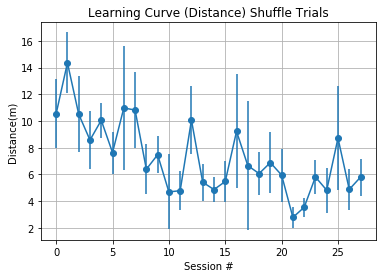

In [68]:
fig, ax = plt.subplots()
session = np.linspace(0,27,28)
ax.errorbar(session, meanValuesDistance,
            yerr=errorValuesDistance,
            fmt='-o')
plt.grid()


ax.set_xlabel('Session #')
ax.set_ylabel('Distance(m)')
ax.set_title('Learning Curve (Distance) Shuffle Trials')

plt.savefig("Images/Shuffle/distance.png")
plt.show()

### Curve Fitting and Chi-Square Testing

In [69]:
from scipy.stats import chisquare

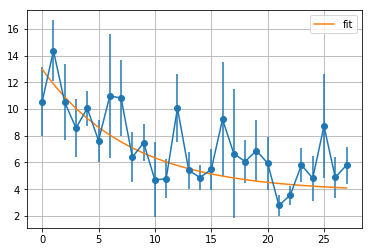

In [70]:
# This is the function we are trying to fit to the data.
def func(x, a, b, c):
     return a * np.exp(-b * x) + c

fig, ax = plt.subplots()
ax.errorbar(session, meanValuesDistance,
            yerr=errorValuesDistance,
            fmt='-o')

plt.grid()
# The actual curve fitting happens here
optimizedParameters, pcov = opt.curve_fit(func, session, meanValuesDistance, sigma=errorValuesDistance)

# Use the optimized parameters to plot the best fit
plt.plot(session, func(session, *optimizedParameters), label="fit")

# Show the graph
plt.legend()
plt.show()

In [71]:
f_exp = []
for j in range(0,len(meanValuesDistance)):
    f_exp.append(func(j, optimizedParameters[0], optimizedParameters[1], optimizedParameters[2]))

f_exp = np.asarray(f_exp)

In [72]:
Cressie_Reed_divergence = chisquare(meanValuesDistance, f_exp)[0]
p_value = chisquare(meanValuesDistance, f_exp)[1]

### Outliers Removal 

In [73]:
# remove outliers from arrays arr = arr[arr != 6] 
if len(find_outliers(distanceTot0)) == 1: 
	distanceTot0 = distanceTot0[distanceTot0 != find_outliers(distanceTot0)[0]]
if len(find_outliers(distanceTot1)) == 1: 
	distanceTot1 = distanceTot1[distanceTot1 != find_outliers(distanceTot1)[0]]
if len(find_outliers(distanceTot2)) == 1: 
	distanceTot2 = distanceTot2[distanceTot2 != find_outliers(distanceTot2)[0]]
if len(find_outliers(distanceTot3)) == 1: 
	distanceTot3 = distanceTot3[distanceTot3 != find_outliers(distanceTot3)[0]]
if len(find_outliers(distanceTot4)) == 1: 
	distanceTot4 = distanceTot4[distanceTot4 != find_outliers(distanceTot4)[0]]
if len(find_outliers(distanceTot5)) == 1: 
	distanceTot5 = distanceTot5[distanceTot5 != find_outliers(distanceTot5)[0]]
if len(find_outliers(distanceTot6)) == 1: 
	distanceTot6 = distanceTot6[distanceTot6 != find_outliers(distanceTot6)[0]]
if len(find_outliers(distanceTot7)) == 1: 
	distanceTot7 = distanceTot7[distanceTot7 != find_outliers(distanceTot7)[0]]
if len(find_outliers(distanceTot8)) == 1: 
	distanceTot8 = distanceTot8[distanceTot8 != find_outliers(distanceTot8)[0]]
if len(find_outliers(distanceTot9)) == 1: 
	distanceTot9 = distanceTot9[distanceTot9 != find_outliers(distanceTot9)[0]]
if len(find_outliers(distanceTot10)) == 1: 
	distanceTot10 = distanceTot10[distanceTot10 != find_outliers(distanceTot10)[0]]
if len(find_outliers(distanceTot11)) == 1: 
	distanceTot11 = distanceTot11[distanceTot11 != find_outliers(distanceTot11)[0]]
if len(find_outliers(distanceTot12)) == 1: 
	distanceTot12 = distanceTot12[distanceTot12 != find_outliers(distanceTot12)[0]]
if len(find_outliers(distanceTot13)) == 1: 
	distanceTot13 = distanceTot13[distanceTot13 != find_outliers(distanceTot13)[0]]
if len(find_outliers(distanceTot14)) == 1: 
	distanceTot14 = distanceTot14[distanceTot14 != find_outliers(distanceTot14)[0]]
if len(find_outliers(distanceTot15)) == 1: 
	distanceTot15 = distanceTot15[distanceTot15 != find_outliers(distanceTot15)[0]]
if len(find_outliers(distanceTot16)) == 1:
	distanceTot16 = distanceTot16[distanceTot16 != find_outliers(distanceTot16)[0]]
if len(find_outliers(distanceTot17)) == 1:
	distanceTot17 = distanceTot17[distanceTot17 != find_outliers(distanceTot17)[0]]
if len(find_outliers(distanceTot18)) == 1:
	distanceTot18 = distanceTot18[distanceTot18 != find_outliers(distanceTot18)[0]]
if len(find_outliers(distanceTot19)) == 1:
	distanceTot19 = distanceTot19[distanceTot19 != find_outliers(distanceTot19)[0]]
if len(find_outliers(distanceTot20)) == 1:
	distanceTot20 = distanceTot20[distanceTot20 != find_outliers(distanceTot20)[0]]
if len(find_outliers(distanceTot21)) == 1:
	distanceTot21 = distanceTot21[distanceTot21 != find_outliers(distanceTot21)[0]]
if len(find_outliers(distanceTot22)) == 1:
	distanceTot22 = distanceTot22[distanceTot22 != find_outliers(distanceTot22)[0]]
if len(find_outliers(distanceTot23)) == 1:
	distanceTot23 = distanceTot23[distanceTot23 != find_outliers(distanceTot23)[0]]
if len(find_outliers(distanceTot24)) == 1:
	distanceTot24 = distanceTot24[distanceTot24 != find_outliers(distanceTot24)[0]]
if len(find_outliers(distanceTot25)) == 1:
	distanceTot25 = distanceTot25[distanceTot25 != find_outliers(distanceTot25)[0]]
if len(find_outliers(distanceTot26)) == 1:
	distanceTot26 = distanceTot26[distanceTot26 != find_outliers(distanceTot26)[0]]
if len(find_outliers(distanceTot27)) == 1:
	distanceTot27 = distanceTot27[distanceTot27 != find_outliers(distanceTot27)[0]]

# Now get average and standard deviation for each 
meanDistanceSession0=distanceTot0.mean()
errorSession0=distanceTot0.std()/np.sqrt(len(distanceTot0))
meanDistanceSession1=distanceTot1.mean()
errorSession1=distanceTot1.std()/np.sqrt(len(distanceTot1))
meanDistanceSession2=distanceTot2.mean()
errorSession2=distanceTot2.std()/np.sqrt(len(distanceTot2))
meanDistanceSession3=distanceTot3.mean()
errorSession3=distanceTot3.std()/np.sqrt(len(distanceTot3))
meanDistanceSession4=distanceTot4.mean()
errorSession4=distanceTot4.std()/np.sqrt(len(distanceTot4))
meanDistanceSession5=distanceTot5.mean()
errorSession5=distanceTot5.std()/np.sqrt(len(distanceTot5))
meanDistanceSession6=distanceTot6.mean()
errorSession6=distanceTot6.std()/np.sqrt(len(distanceTot6))
meanDistanceSession7=distanceTot7.mean()
errorSession7=distanceTot7.std()/np.sqrt(len(distanceTot7))
meanDistanceSession8=distanceTot8.mean()
errorSession8=distanceTot8.std()/np.sqrt(len(distanceTot8))
meanDistanceSession9=distanceTot9.mean()
errorSession9=distanceTot9.std()/np.sqrt(len(distanceTot9))
meanDistanceSession10=distanceTot10.mean()
errorSession10=distanceTot10.std()/np.sqrt(len(distanceTot10))
meanDistanceSession11=distanceTot11.mean()
errorSession11=distanceTot11.std()/np.sqrt(len(distanceTot11))
meanDistanceSession12=distanceTot12.mean()
errorSession12=distanceTot12.std()/np.sqrt(len(distanceTot12))
meanDistanceSession13=distanceTot13.mean()
errorSession13=distanceTot13.std()/np.sqrt(len(distanceTot13))
meanDistanceSession14=distanceTot14.mean()
errorSession14=distanceTot14.std()/np.sqrt(len(distanceTot14))
meanDistanceSession15=distanceTot15.mean()
errorSession15=distanceTot15.std()/np.sqrt(len(distanceTot15))
meanDistanceSession16=distanceTot16.mean()
errorSession16=distanceTot16.std()/np.sqrt(len(distanceTot16))
meanDistanceSession17=distanceTot17.mean()
errorSession17=distanceTot17.std()/np.sqrt(len(distanceTot17))
meanDistanceSession18=distanceTot18.mean()
errorSession18=distanceTot18.std()/np.sqrt(len(distanceTot18))
meanDistanceSession19=distanceTot19.mean()
errorSession19=distanceTot19.std()/np.sqrt(len(distanceTot19))
meanDistanceSession20=distanceTot20.mean()
errorSession20=distanceTot20.std()/np.sqrt(len(distanceTot20))
meanDistanceSession21=distanceTot21.mean()
errorSession21=distanceTot21.std()/np.sqrt(len(distanceTot21))
meanDistanceSession22=distanceTot22.mean()
errorSession22=distanceTot22.std()/np.sqrt(len(distanceTot22))
meanDistanceSession23=distanceTot23.mean()
errorSession23=distanceTot23.std()/np.sqrt(len(distanceTot23))
meanDistanceSession24=distanceTot24.mean()
errorSession24=distanceTot24.std()/np.sqrt(len(distanceTot24))
meanDistanceSession25=distanceTot25.mean()
errorSession25=distanceTot25.std()/np.sqrt(len(distanceTot25))
meanDistanceSession26=distanceTot26.mean()
errorSession26=distanceTot26.std()/np.sqrt(len(distanceTot26))
meanDistanceSession27=distanceTot27.mean()
errorSession27=distanceTot27.std()/np.sqrt(len(distanceTot27))

meanValuesDistance = np.array([meanDistanceSession0,meanDistanceSession1,meanDistanceSession2,meanDistanceSession3,
                               meanDistanceSession4,meanDistanceSession5, meanDistanceSession6, meanDistanceSession7,
                               meanDistanceSession8,meanDistanceSession9,meanDistanceSession10,meanDistanceSession11,
                               meanDistanceSession12,meanDistanceSession13,meanDistanceSession14,meanDistanceSession15
                              ,meanDistanceSession16,meanDistanceSession17,meanDistanceSession18,meanDistanceSession19
                               ,meanDistanceSession20,meanDistanceSession21,meanDistanceSession22,meanDistanceSession23
                               ,meanDistanceSession24,meanDistanceSession25,meanDistanceSession26,meanDistanceSession27])

errorValuesDistance = np.array([errorSession0,errorSession1,errorSession2,errorSession3,errorSession4,errorSession5
                                ,errorSession6,errorSession7,errorSession8,errorSession9,errorSession10,errorSession11
                                ,errorSession12,errorSession13,errorSession14,errorSession15,errorSession16,errorSession17
                                ,errorSession18,errorSession19,errorSession20,errorSession21,errorSession22,errorSession23
                                ,errorSession24,errorSession25,errorSession26,errorSession27])

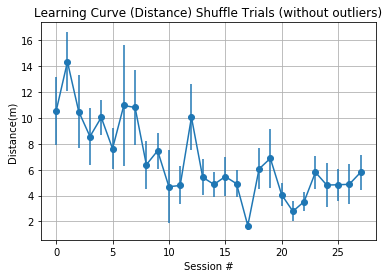

In [74]:
fig, ax = plt.subplots()
session = np.linspace(0,27,28)
ax.errorbar(session, meanValuesDistance,
            yerr=errorValuesDistance,
            fmt='-o')
plt.grid()


ax.set_xlabel('Session #')
ax.set_ylabel('Distance(m)')
ax.set_title('Learning Curve (Distance) Shuffle Trials (without outliers)')

plt.savefig("Images/Shuffle/distance_no_outlier.png")

plt.show()

## Learning Curves Comparison

In [75]:
img1 = mpimg.imread('Images/Shuffle/duration.png')
img2 = mpimg.imread('Images/Shuffle/duration_no_outliers.png')
img3 = mpimg.imread('Images/Shuffle/distance.png')
img4 = mpimg.imread('Images/Shuffle/distance_no_outlier.png')

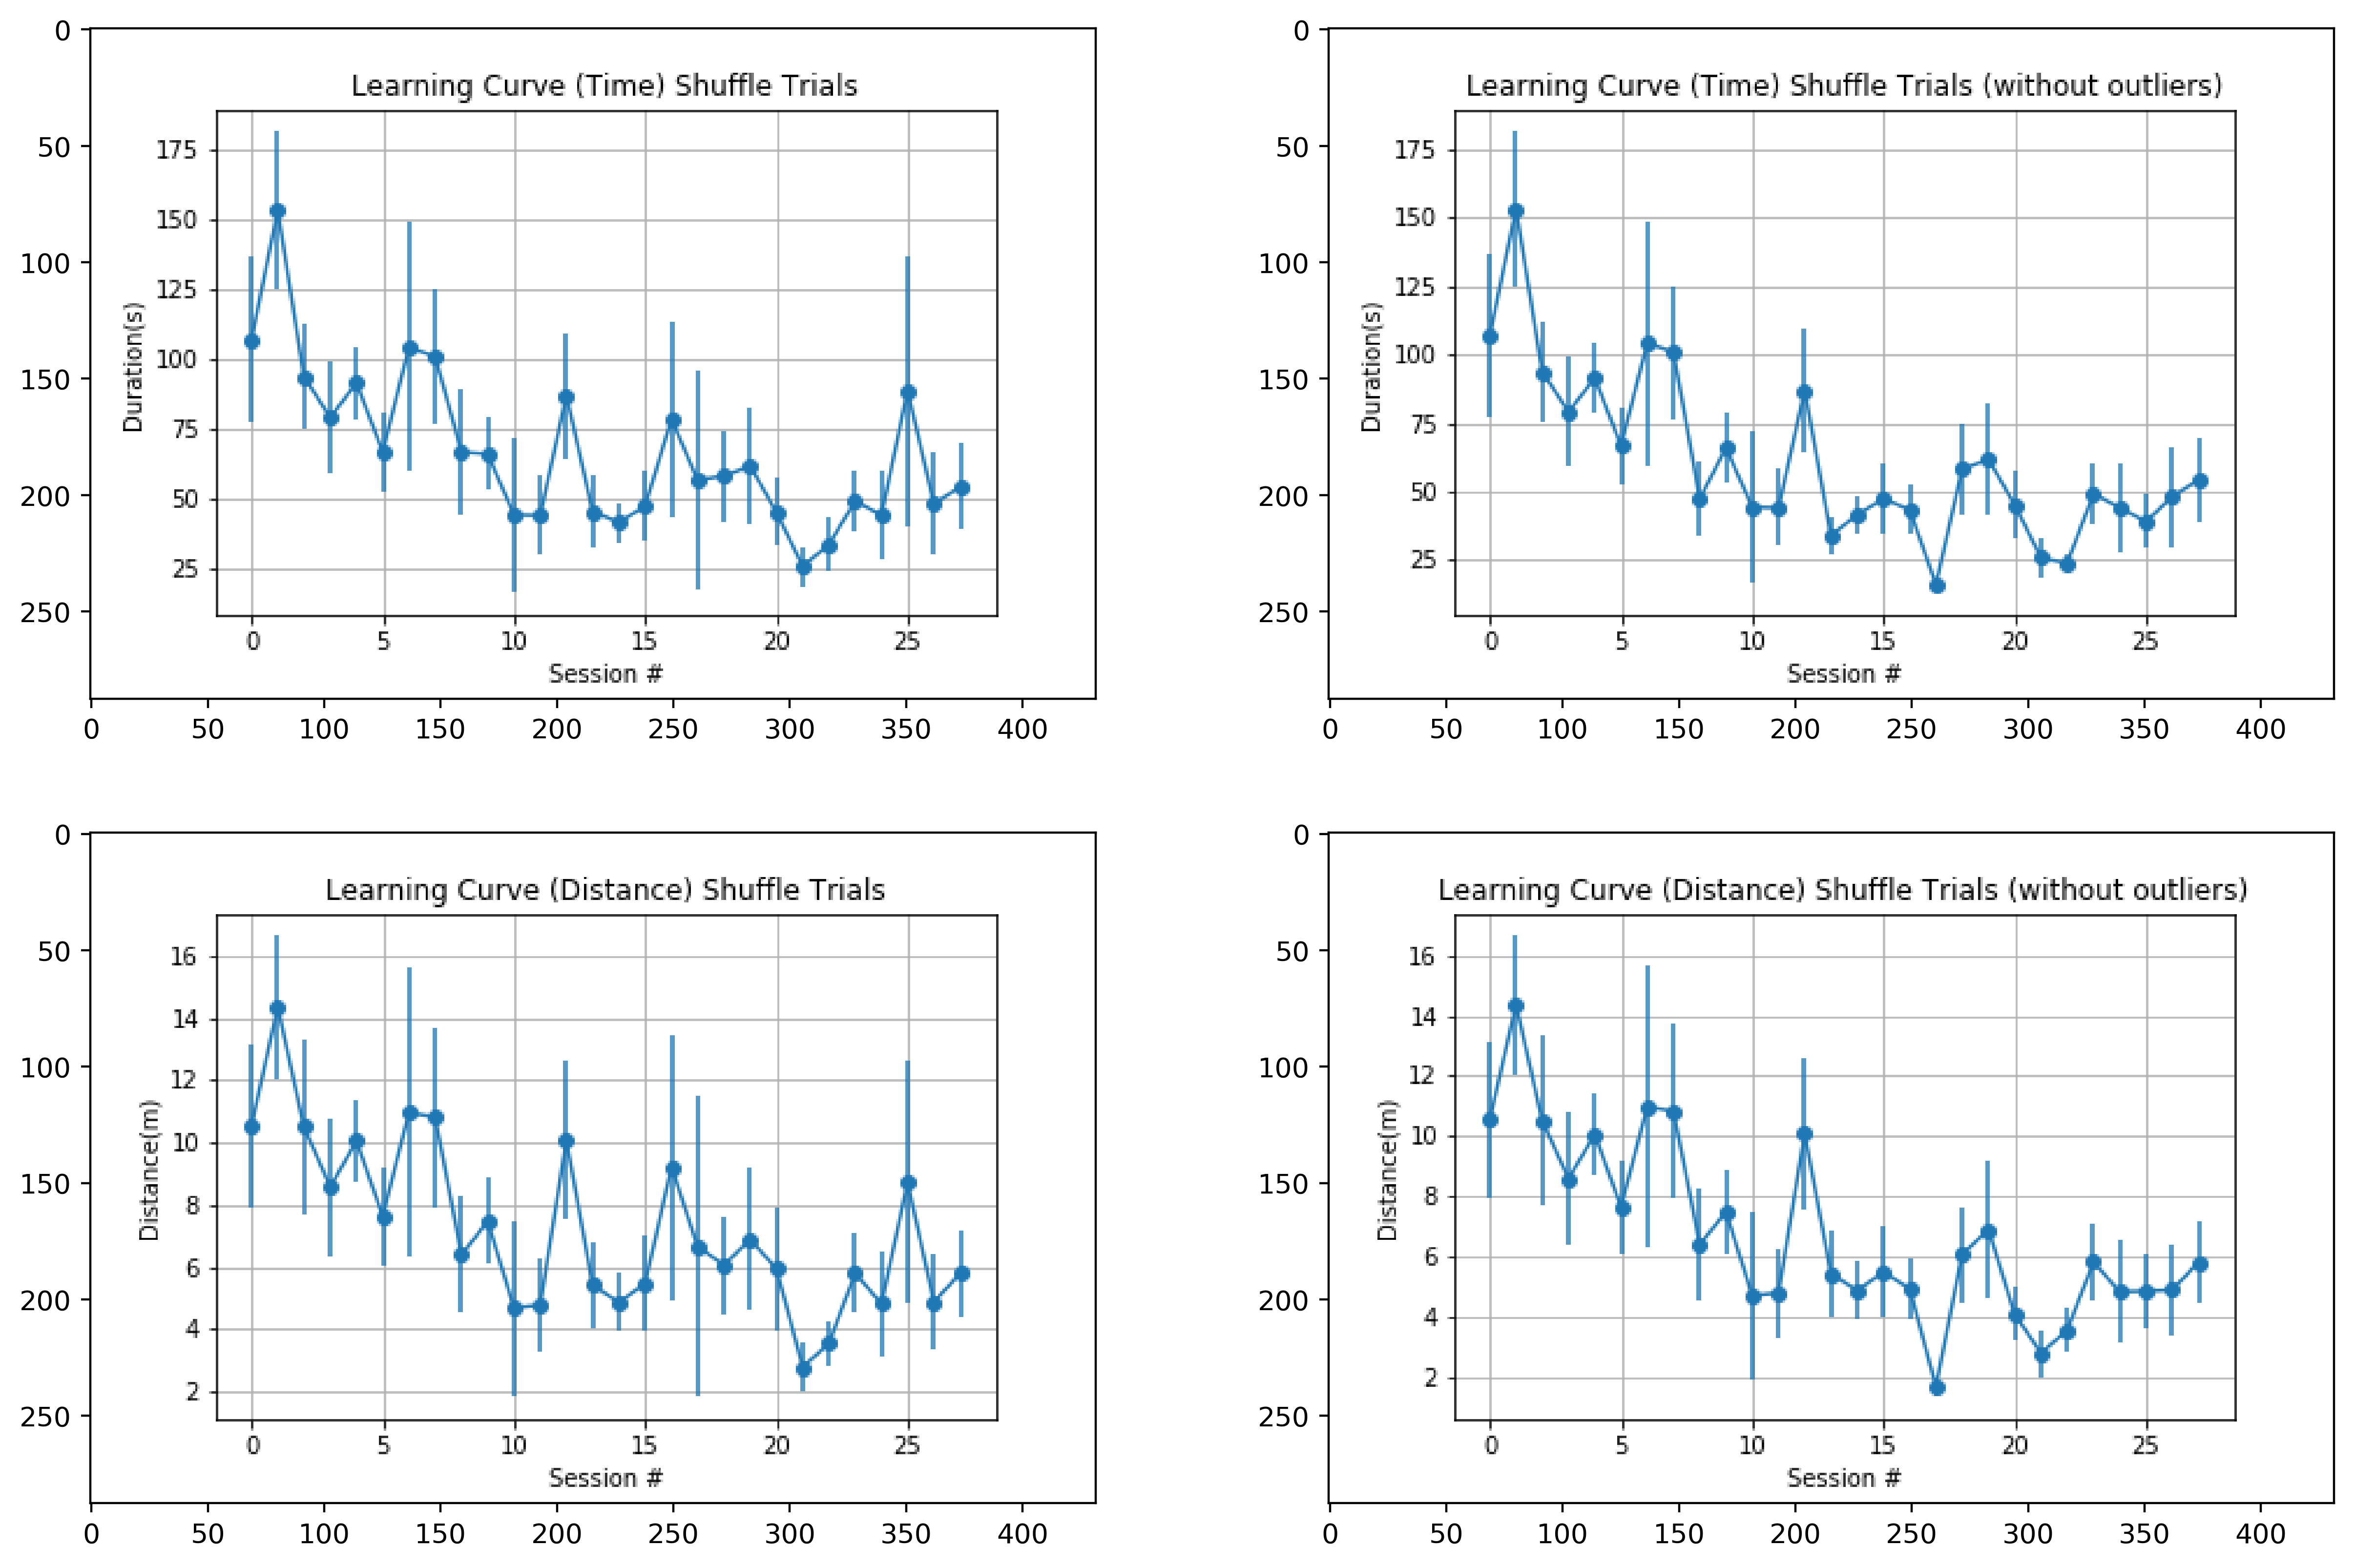

In [76]:
f, axarr = plt.subplots(2,2, figsize=(15,10), dpi = 400)
axarr[0,0].imshow(img1)
axarr[0,1].imshow(img2)
axarr[1,0].imshow(img3)
axarr[1,1].imshow(img4)

# ANOVA 
Overall probability of the Early, Late, Probe Trials coming from the same distribution 

In [77]:
EarlyPositionsAnova = np.concatenate((distanceTot0,distanceTot1), axis = 0)
LatePositionsAnova = np.concatenate((distanceTot20,distanceTot21,distanceTot22,distanceTot23,distanceTot24,distanceTot25,distanceTot26,distanceTot27), axis = 0)

In [78]:
# We can print this guy 
F, p = stats.f_oneway(EarlyPositionsAnova, LatePositionsAnova)
print('F = ',F, 'p-value =',p)

F =  41.32240757918065 p-value = 3.506081801698301e-09


In [79]:
EarlyDurationAnova = np.concatenate((durationSession0,durationSession1), axis = 0)
LateDurationAnova = np.concatenate((durationSession20,durationSession21,durationSession22,durationSession23,durationSession24,durationSession25,durationSession26,durationSession27), axis = 0)

In [80]:
# We can print this guy 
F, p = stats.f_oneway(EarlyDurationAnova,  LateDurationAnova, durationProbe)
print('F = ',F, 'p-value =',p)

F =  252.70172273487174 p-value = 1.5693439927640749e-46
